#ResNet18 로 명화 분류

dataset: kaggle의 해당 코드에 있는 dataset https://www.kaggle.com/code/yasamanasgary/best-artworks-artist-predition-via-pytorch/notebook 

model : Resnet18(weight)      <--  Resnet에 class마다의 가중치값 적용한 모델

명화분류로 해당 모델이 그림 분류에 괜찮은지 확인용 -> accuracy 75나왔고 epoch마다 증가하고 있으니까 괜찮은듯

10개의 class로 분류

# 1. 필요 라이브러리 임포트

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline


# 데이터 불러오기
10개의 화가 그림있는 디렉터리 가져오기

temp_art 디렉토리

temp_art/

|-- Alfred_Sisley/

    |-- Alfred_Sisley_0.jpg

    |-- Alfred_Sisley_1.jpg

    |-- Alfred_Sisley_2.jpg

    |-- ...

|-- Edgar_Degas/

    |-- Edgar_Degas_0.jpg

    |-- Edgar_Degas_1.jpg

    |-- Edgar_Degas_2.jpg

    |-- ...
.
.
.


*dataset.ImageFolder(images_dir) : 계층적 폴더 구조를 가진 dataset 을 가져올 때 사용
각 이미지들이 자신의 레이블(Label) 이름으로 된 폴더 안에 들어가 있는 구조일 때

<참고> torchvision.datasets : 특징(feature) 와 정답(label)을 저장

** transforms.Compose() : augmentation을 위한 이미지 변환을 한번에 적용할 수 있는 메서드, 해당 부분은 테스트해가면서 조정하기

[https://pytorch.org/vision/stable/transforms.html](https://pytorch.org/vision/stable/transforms.html)

`transforms.ToTensor()` : PIL image나 numpy.ndarray를 tensor로 변환한다. 

- PIL image(pillow)
    
    파이썬에서 이미지를 핸들링하기 위한 패키지(opencv같은 거) 인 PIL로 받은 image
    

[`normalize(tensor, mean, std[, inplace])` **:** float인 tensor image를 mean과 standard deviation으로 normalize한다.

[`RandomCrop](size[, padding, pad_if_needed, …])`  **:** 랜덤 위치에서 주어진 이미지를 crop한다.

[`RandomHorizontalFlip]([p])` **:** 입력된 probability로 랜덤 수평뒤집기



In [ ]:
images_dir = '/content/drive/MyDrive/ml_workplace/ml_art_prac/images/temp_art'

transform = transforms.Compose([ 
      transforms.Resize((100,100)),   
      transforms.ToTensor()])
dataset = ImageFolder(images_dir, transform = transform)   #from torchvision.datasets import ImageFolder
dataset.classes


['Alfred_Sisley',
 'Edgar_Degas',
 'Francisco_Goya',
 'Marc_Chagall',
 'Pablo_Picasso',
 'Paul_Gauguin',
 'Pierre-Auguste_Renoir',
 'Rembrandt',
 'Titian',
 'Vincent_van_Gogh']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


데이터셋 잘 불러왔는지 확인

transpose(a,b) : a차원과 b차원을 교환 


In [ ]:
def visualize_sample(sample):
    print("Class is:", sample[1])
    plt.imshow(sample[0].transpose(0, 1).transpose(1, 2))    # sample[0] 텐서는 (3, 100, 100) 으로 [channel, width, height] 인데, imshow의 인자는 [height, width, channel]순이여야함 

Class is: 0


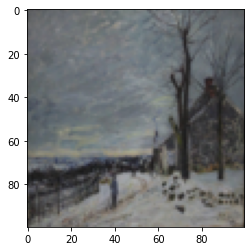

In [ ]:
visualize_sample(dataset[0])

Class is: 1


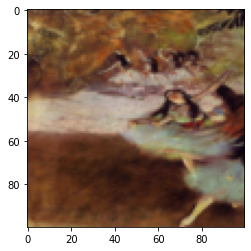

In [ ]:
visualize_sample(dataset[500])

#검증을 위한 데이터 분할

In [ ]:
train_length = round(len(dataset) * 0.7)
val_length = len(dataset) - train_length             #3971data 중 70퍼가 train data, 30퍼가 test data
train, val = random_split(dataset, [train_length, val_length])      #datase   t에서 랜덤하고 겹치지 않게 주어진 길이만큼 이미지는 쪼갠다 
print(len(dataset)) 

3971


Class is: 5


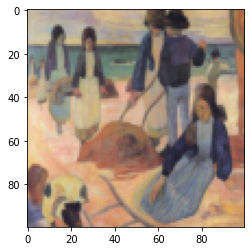

In [ ]:
visualize_sample(train[0])        #랜덤하게 나눴으니까 실행마다 바뀜

Class is: 5


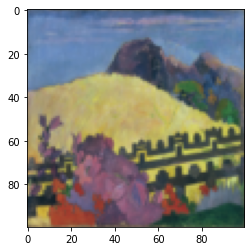

In [ ]:
visualize_sample(val[0])

#모델 학습 준비

In [ ]:
#gpu 사용 가능한지 확인하기

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"    #colab GPU사용량 초과해서 cpu사용 -> false출력
    
print(torch.cuda.is_available())

False


resnet18('Weights','none') : weights: class에 대한 가중치(입력안하니까 정확도 낮아서 입력함),  pretrained = none :  pretrained = True 면 다른 큰 데이터셋에서 train되었던 resnet 을 가져옴

In [ ]:
#ResNET 사용하기위해 weight 구함

#class의 가중치를 구하기 위해 artist의 작품갯수 정보있는 csv파일 가져옴

artists = pd.read_csv('/content/drive/MyDrive/ml_workplace/ml_art_prac/artists_temp.csv')     #read_csv : csv파일을 dataframe 형식으로 가져옴
print(artists.shape)     #dataframe의 행과 열갯수 출력

artists_weight = artists[['name', 'paintings']]       #weights 넣을 새로운 dataframe만들기

artists_weight['class_weight'] = artists_weight.paintings.sum() / (artists_weight.shape[0] * artists_weight.paintings)   #class a 의 가중치 = # of a / # of 전체작품

print(artists_weight)

class_weights = artists_weight['class_weight'].to_dict()    #dataframe을 dictionary 형태로 => model함수에 넣을 수 있게
print(class_weights)

model = models.resnet18(class_weights).to(device)   #resnet 18사용, weight 입력

(10, 8)
                    name  paintings  class_weight
0       Vincent van Gogh        877      0.452794
1          Pablo Picasso        439      0.904556
2  Pierre-Auguste Renoir        336      1.181845
3         Francisco Goya        291      1.364605
4          Alfred Sisley        259      1.533205
5           Marc Chagall        239      1.661506
6            Edgar Degas        702      0.565670
7              Rembrandt        262      1.515649
8                 Titian        255      1.557255
9           Paul Gauguin        311      1.276849
{0: 0.45279361459521095, 1: 0.9045558086560365, 2: 1.181845238095238, 3: 1.3646048109965636, 4: 1.5332046332046332, 5: 1.6615062761506276, 6: 0.5656695156695156, 7: 1.515648854961832, 8: 1.5572549019607844, 9: 1.2768488745980708}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
criterion = torch.nn.CrossEntropyLoss()   #손실함수(loss function) 선택, 예측값과 실제값의 차이를 구한다.
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)  # 최적화 모델 선택, 모델의 매개변수(model.parameters())를 조정해서 모델을 최적화 시킨다.        

#optim.SGD : 옵티마이저 중 stochastic gradient descent
#lr : learning rate     낮으면 학습 느리고, 너무 크면 overfitting 일어나서 오차 커짐
#속도 느려서 lr 0.01로 하니까 overfitting 일어남. 0.001이 딱 좋은듯=> 추후조정

In [ ]:
BATCH_SIZE = 16     #GPU안돌아가서 배치 32-> 16으로 줄임
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)

#batch : 학습의 한 반복자(iter)를 epoch이라 하는데, 한 epoch에 들어가는 data의 수를 batchsize 라 한다
#DataLoader : batchsize 에 맞게 iterable한 객체로 dataset 에 접근한다.  -> for x, y in dataloader 표현 가능 


In [ ]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

#모델 평가

In [ ]:
def get_accuracy(model, loader):   #모델의 정확도를 구하는 함수
    model.eval()                  #resnet과 같은 model은 eval() <- 평가모드 와 train() <- 학습모드로 지정함에 따라 필요한 매개변수를 키고 끌 수 있으니 항상 적절하게 바꿔줘야함
    total = 0                     #loader의 전체 데이터수를 담을 변수
    correct = 0                   #모델의 정확도를 담을 변수
    for x, y in tqdm(loader):     # dataloader는 한 iter에 batchsize 만큼의 데이터를 가져옴, 만약 batchsize가 k라면   x : feature [k, 10, , ] <-- 10은 class수   y : lable [k] 의 size를 가질거임  
        x = x.to(device)

        y = y.to(device)
        
        pred = model(x)           #feature을 model에 넣어 prediction값 구하기, 
        total += y.shape[0]       #shape[0] : 행의 갯수, 즉 batchsize가 됨
        correct += (y == pred.argmax(1)).sum().item()     #일치정도를 구하는 방법 : pred.argmax(1) => pred의 1차원 ([k, 10, , ]에서 10인 class에 해당)중 값이 가장 큰 것이 몇 번째인지 알려줌. 즉 측정한 class알려줌
                                                          #y은 label이니까 한 batch의 k개의 데이터 중 label = 예측값 인거 찾기
                                                          #.sum()은 해당 조건 만족하는 갯수, .item()은 scalar 값으로 표현
        
        #print("pred.argmax(1) = ", pred.argmax(1))
        
        #print("pred.argmax(1).size = ", pred.argmax(1).size())
        
        #print("pred.argmax(1).max = ", pred.argmax(1).max())
        
        #print("y ", y)   디버그용
        
    return correct / total          #예측과 일치한 데이터 수 / 전체 데이터 수

In [ ]:
get_accuracy(model, val_loader)         # train전에 확인



100%|██████████| 75/75 [05:24<00:00,  4.32s/it]


0.0016792611251049538

#모델 학습

학습 3단계 1. optimizer초기화, 2. loss.backwards() <- background propagation 3. optimizer.step()가중치갱신

In [ ]:
def train_epoch(model, loader):      #한 epoch에 모델학습하는 함수
    total = 0
    correct = 0
    total_loss = 0
    for x, y in tqdm(loader):
        optimizer.zero_grad()      # optimizer 파라미터 초기화    
        x = x.to(device)
        y = y.to(device)
        pred = model(x)           #예측값
        loss = criterion(pred, y)     #loss계산하고
        loss.backward()             # background propagation   각 매개변수에 대한 손실의 변화도 저장

        total += y.shape[0]
        correct += (y == pred.argmax(1)).sum().item()
        total_loss += loss.item()

        optimizer.step()        #background propagation 결과로 parameter새로 업뎃

    accuracy = correct / total
    average_loss = total_loss / len(loader)
    
    return accuracy, average_loss

In [ ]:
best_val_acc = 0
for epoch in range(20):
    
    print("Epoch {}".format(epoch + 1).center(40).center(80, "#"))
    train_acc, train      _loss = train_epoch(model, train_loader)
    val_acc = get_accuracy(model, val_loader)
    
    print("train_acc={:.5f} train_loss={:.5f} val_acc={:.5f}".format(train_acc, train_loss, val_acc))
    
    if val_acc > best_val_acc:            # 만약 새로운 epoch에 더 좋은 정확도 나오면 모델 새로 저장
        best_val_acc = val_acc
        torch.save(model.state_dict(), "model.pt")
        print("Saved model to `model.pt`")

####################                Epoch 1                 ####################


100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


train_acc=0.28561 train_loss=2.40795 val_acc=0.43913
Saved model to `model.pt`
####################                Epoch 2                 ####################


100%|██████████| 75/75 [00:54<00:00,  1.37it/s]


train_acc=0.44820 train_loss=1.59690 val_acc=0.46599
Saved model to `model.pt`
####################                Epoch 3                 ####################


100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


train_acc=0.52302 train_loss=1.37344 val_acc=0.60369
Saved model to `model.pt`
####################                Epoch 4                 ####################


100%|██████████| 75/75 [00:56<00:00,  1.33it/s]


train_acc=0.59065 train_loss=1.19851 val_acc=0.55080
####################                Epoch 5                 ####################


100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


train_acc=0.63813 train_loss=1.05167 val_acc=0.64903
Saved model to `model.pt`
####################                Epoch 6                 ####################


100%|██████████| 75/75 [00:54<00:00,  1.37it/s]


train_acc=0.67590 train_loss=0.94897 val_acc=0.57767
####################                Epoch 7                 ####################


100%|██████████| 75/75 [00:54<00:00,  1.36it/s]


train_acc=0.71655 train_loss=0.84115 val_acc=0.67674
Saved model to `model.pt`
####################                Epoch 8                 ####################


100%|██████████| 75/75 [00:56<00:00,  1.33it/s]


train_acc=0.75324 train_loss=0.73381 val_acc=0.65827
####################                Epoch 9                 ####################


100%|██████████| 75/75 [00:55<00:00,  1.35it/s]


train_acc=0.77086 train_loss=0.67352 val_acc=0.50378
####################                Epoch 10                ####################


100%|██████████| 75/75 [00:55<00:00,  1.36it/s]


train_acc=0.82374 train_loss=0.52733 val_acc=0.66415
####################                Epoch 11                ####################


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


train_acc=0.83813 train_loss=0.49092 val_acc=0.68178
Saved model to `model.pt`
####################                Epoch 12                ####################


100%|██████████| 75/75 [00:55<00:00,  1.35it/s]


train_acc=0.87230 train_loss=0.38884 val_acc=0.70697
Saved model to `model.pt`
####################                Epoch 13                ####################


100%|██████████| 75/75 [00:55<00:00,  1.35it/s]


train_acc=0.89281 train_loss=0.34871 val_acc=0.61377
####################                Epoch 14                ####################


100%|██████████| 75/75 [00:56<00:00,  1.33it/s]


train_acc=0.92122 train_loss=0.25552 val_acc=0.71704
Saved model to `model.pt`
####################                Epoch 15                ####################


100%|██████████| 75/75 [00:56<00:00,  1.33it/s]


train_acc=0.94424 train_loss=0.18609 val_acc=0.72964
Saved model to `model.pt`
####################                Epoch 16                ####################


100%|██████████| 75/75 [00:55<00:00,  1.35it/s]


train_acc=0.95468 train_loss=0.15846 val_acc=0.69270
####################                Epoch 17                ####################


100%|██████████| 75/75 [00:55<00:00,  1.34it/s]


train_acc=0.98022 train_loss=0.09220 val_acc=0.73384
Saved model to `model.pt`
####################                Epoch 18                ####################


100%|██████████| 75/75 [00:56<00:00,  1.32it/s]


train_acc=0.96331 train_loss=0.16524 val_acc=0.73048
####################                Epoch 19                ####################


100%|██████████| 75/75 [00:56<00:00,  1.33it/s]


train_acc=0.99388 train_loss=0.05127 val_acc=0.75231
Saved model to `model.pt`
####################                Epoch 20                ####################


100%|██████████| 75/75 [00:56<00:00,  1.34it/s]

train_acc=1.00000 train_loss=0.02318 val_acc=0.74979


In [ ]:
torch.save(model.state_dict(), "model.pt")    #모델 저장하기

# Sanity Test 검증단계

In [ ]:
model.load_state_dict(torch.load("model.pt", map_location="cpu"))    #모델 불러오기

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
get_accuracy(model, val_loader)

100%|██████████| 75/75 [00:56<00:00,  1.34it/s]


0.7497900923593619

In [ ]:
from PIL import Image

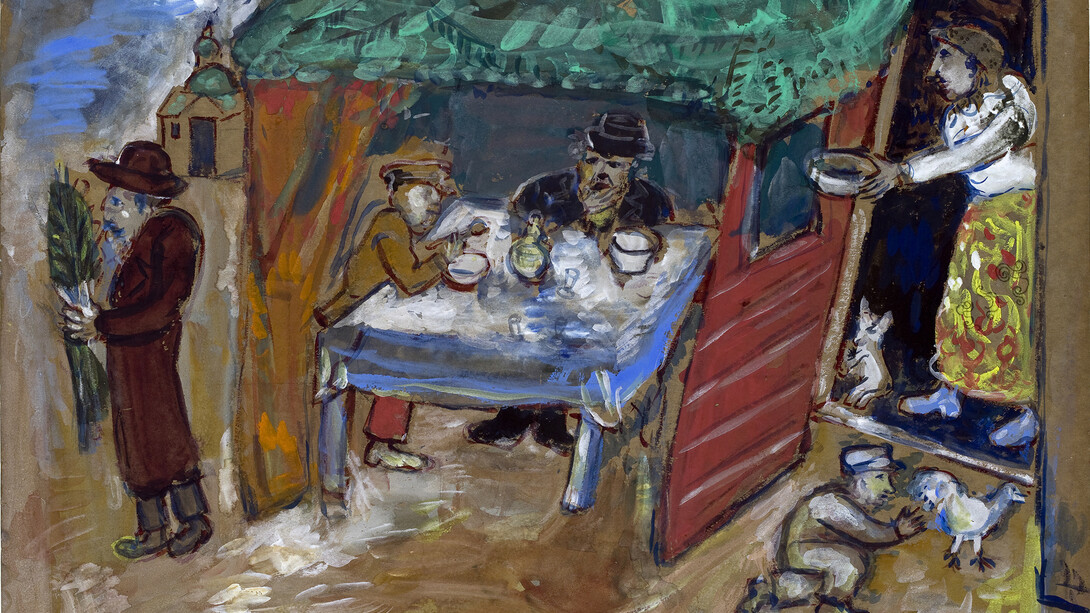

In [ ]:
image = Image.open("/content/drive/MyDrive/ml_workplace/ml_art_prac/images/test_temp/Chagall_1.jpg")
image



In [ ]:
image = transform(image)
model = model.to("cpu")
model.eval()

prediction = model(image.unsqueeze(0))
print(prediction)
prediction = prediction.argmax()

tensor([[ 2.1016e+01,  2.5194e+01,  2.1569e+01,  3.4163e+01,  3.2574e+01,
          2.5881e+01,  2.5302e+01,  1.4191e+01,  1.6367e+01,  2.0396e+01,
         -2.3888e+00,  9.5533e-01,  3.0669e+00,  1.7848e+00, -1.1513e+00,
          7.8986e-01, -8.5301e-01, -4.4828e-01,  6.8671e-01, -8.3121e-01,
          1.1190e+00,  7.9560e+00,  2.6213e-01,  6.8255e+00, -1.3632e+00,
          5.8053e-01,  3.7980e+00,  9.6164e-01, -1.5550e-01,  1.8167e+01,
          4.2694e+00, -9.8695e-01,  1.5024e+00,  1.6586e+01,  7.5182e+00,
          8.7320e+00,  8.6418e+00,  7.2542e+00,  4.9207e+00,  4.6184e+00,
          4.2893e+00,  2.7985e+00,  6.5716e-01,  4.5221e+00,  5.1966e+00,
          1.7755e+00,  3.1294e+00, -5.1089e+00,  1.0958e+00,  4.6544e+00,
          6.9925e+00,  1.0532e+01, -3.8516e+00, -6.0526e+00, -2.9256e+00,
         -2.9929e+00, -5.9038e+00, -2.9357e+00,  2.6810e+00, -4.7864e+00,
         -4.2684e-01,  5.0287e-01,  3.9826e+00,  1.9356e+00, -5.3622e-01,
          7.2941e+00, -1.1109e+00, -1.

In [ ]:
model.fc._parameters

OrderedDict([('weight', Parameter containing:
              tensor([[-0.0174, -0.0702, -0.0513,  ..., -0.0410,  0.1746, -0.0415],
                      [-0.0791, -0.0987,  0.0270,  ...,  0.2181, -0.0263,  0.0426],
                      [-0.0311, -0.0538, -0.0181,  ..., -0.0370, -0.0181,  0.0195],
                      ...,
                      [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
                      [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
                      [ 0.0021, -0.0249, -0.0830,  ...,  0.0417, -0.0501,  0.0663]],
                     requires_grad=True)), ('bias', Parameter containing:
              tensor([-4.9354e-04,  9.9027e-03,  4.5330e-03, -2.5682e-02,  7.7210e-03,
                       1.5589e-02, -8.8866e-03,  2.1208e-02, -1.2029e-03, -5.8939e-03,
                      -1.2637e-02, -7.2646e-03, -1.9359e-02, -2.4979e-02, -1.1935e-02,
                      -8.3866e-03, -9.6073e-03, -1.6683e-02,  9.1246e-03, -1.5370e-02,


In [ ]:
if prediction == 0:
    print("It's Alfred_Sisley")
elif prediction == 1:
    print("It's Edgar_Degas")
elif prediction == 2:
    print("It's Francisco_Goya")
elif prediction == 3:
    print("It's Marc_Chagall")
elif prediction == 4:
    print("It's Pablo_Picasso")
elif prediction == 5:
    print("It's Paul_Gauguin")
elif prediction == 6:
    print("It's Pierre_Auguste_Renoir")
elif prediction == 7:
    print("It's Rembrandt")       
elif prediction == 8:
    print("It's Titian")   
elif prediction == 9:
    print("It's Vincent")   
 




It's Marc_Chagall
